           Date     Open     High      Low    Close         Volume  \
0  Jul 31, 2017  2763.24  2889.62  2720.61  2875.34    860,575,000   
1  Jul 30, 2017  2724.39  2758.53  2644.85  2757.18    705,943,000   
2  Jul 29, 2017  2807.02  2808.76  2692.80  2726.45    803,746,000   
3  Jul 28, 2017  2679.73  2897.45  2679.73  2809.01  1,380,100,000   
4  Jul 27, 2017  2538.71  2693.32  2529.34  2671.78    789,104,000   

       Market Cap  
0  45,535,800,000  
1  44,890,700,000  
2  46,246,700,000  
3  44,144,400,000  
4  41,816,500,000  


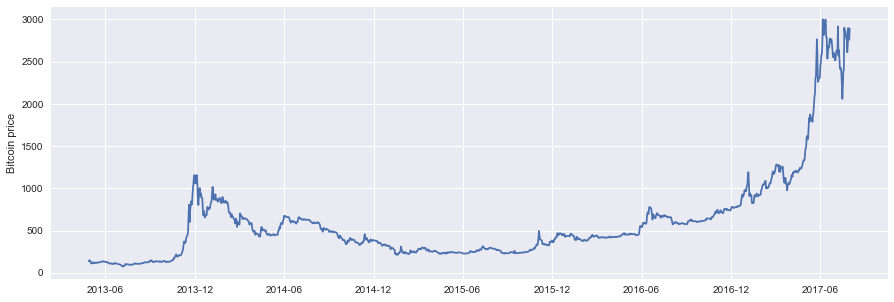

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pyflux as pf
from datetime import datetime
from pandas_datareader.data import DataReader
from dateutil.parser import parse
from datetime import datetime

%matplotlib inline

def convert(date):
    holder = []
    for i in date:
        tp = parse(i).timestamp()
        dt = datetime.fromtimestamp(tp)
        holder.append(dt)
    return np.array(holder)

data_location = '/home/sarai/Documents/data pybr/bitcoin-price-prediction/bitcoin_price_Training - bitcoin_price2013Apr-2017Aug.csv'
raw_price_data = pd.read_csv(data_location)

print(raw_price_data.head())

raw_price_data = raw_price_data[::-1] 
date = raw_price_data['Date'].values
date_n = convert(date)
raw_price_data['Date'] = date_n
raw_price_data = raw_price_data.set_index('Date')

plt.figure(figsize=(15,5))
plt.plot(raw_price_data.index, raw_price_data['High'])
plt.ylabel('Bitcoin price');

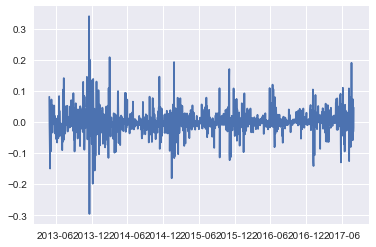

In [5]:
# Make the series stacionary
raw_price_data = np.log(raw_price_data.High)
raw_price_data_diff = raw_price_data - raw_price_data.shift()
plt.plot(raw_price_data_diff)

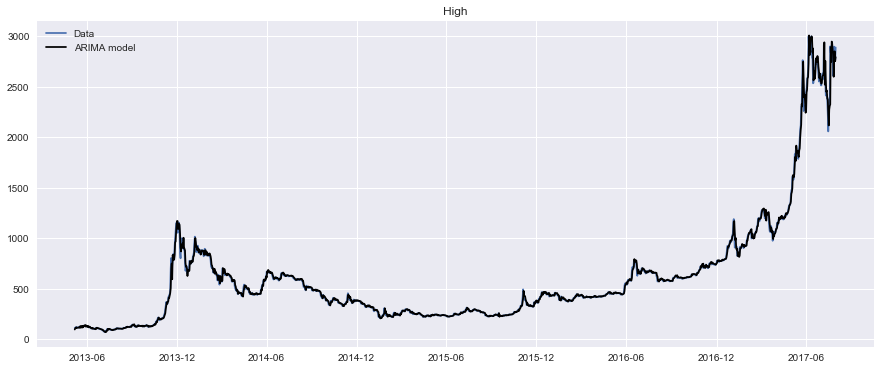

In [8]:
raw_price_data = pd.read_csv(data_location)
raw_price_data = raw_price_data[::-1] 
date = raw_price_data['Date'].values
date_n = convert(date)
raw_price_data['Date'] = date_n
raw_price_data = raw_price_data.set_index('Date')

model = pf.ARIMA(ar=9, ma=2, data=raw_price_data, target='High')
# The distribution for the time series
model.adjust_prior([0], pf.Exponential())
# maximum likelihood point | is a method of estimating the parameters of a statistical model given observations, 
# by finding the parameter values that maximize the likelihood of making the observations given the parameters.
x = model.fit('MLE', nsims=50000)
model.plot_fit(figsize=(15,6))

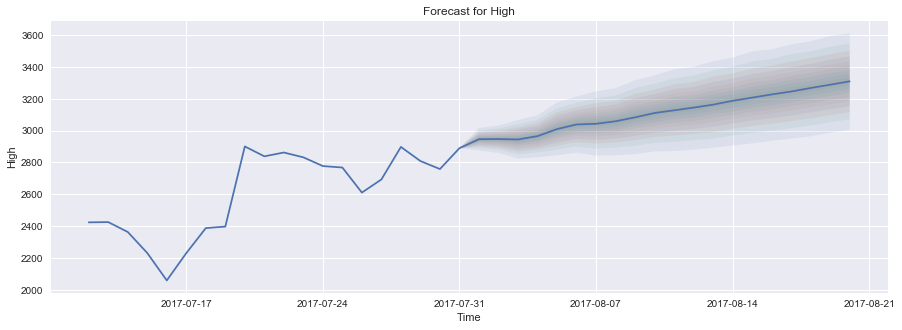

In [9]:
# h = How many steps to forecast ahead
model.plot_predict(h=20,past_values=20,figsize=(15,5))

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

Using TensorFlow backend.


In [11]:
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [14]:
df = raw_price_data

                Open      High       Low     Close
Date                                              
2013-04-28  0.023156  0.020996  0.023989  0.023989
2013-04-29  0.022858  0.024930  0.024674  0.024674
2013-04-30  0.026172  0.024739  0.024692  0.024692
2013-05-01  0.024439  0.022332  0.015204  0.015204
2013-05-02  0.016598  0.017447  0.009640  0.009640


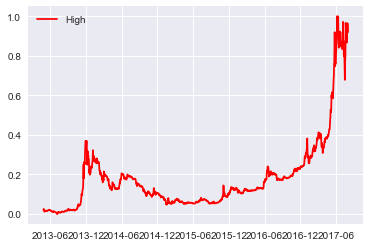

In [17]:
df = raw_price_data
df.drop(['Volume', 'Market Cap'], 1, inplace=True)

min_max_scaler = preprocessing.MinMaxScaler()
df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
df['Close'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
print(df.head())
plt.plot(df['High'], color='red', label='High')
plt.legend(loc='best')
plt.show()

In [23]:
from sklearn.model_selection import train_test_split

training = df

x_train, x_test, y_train, y_test = train_test_split(
    training, training.High, train_size=0.85
)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

1322
234
1322
234


In [26]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [27]:
x_train, y_train, x_test, y_test = load_data(df, seq_len)

In [28]:
# Stack 3 LSTM layers on top of each other, making the model capable of learning higher-level temporal representations.
def build_model(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    # Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [29]:
model = build_model(shape, neurons, d)
# layers = [4, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 1242 samples, validate on 138 samples
Epoch 1/300
1242/1242 [==============================] - 3s - loss: 0.0182 - acc: 8.0515e-04 - val_loss: 0.0712 - val_acc: 0.0000e+00
Epoch 2/300
1242/1242 [==============================] - 2s - loss: 0.0154 - acc: 8.0515e-04 - val_loss: 0.0508 - val_acc: 0.0000e+00
Epoch 3/300
1242/1242 [==============================] - 2s - loss: 0.0081 - acc: 8.0515e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 4/300
1242/1242 [==============================] - 3s - loss: 0.0041 - acc: 8.0515e-04 - val_loss: 0.0040 - val_acc: 0.0000e+00
Epoch 5/300
1242/1242 [==============================] - 2s - loss: 0.0017 - acc: 8.0515e-04 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 6/300
1242/1242 [==============================] - 2s - loss: 0.0030 - acc: 8.0515e-04 - val_loss: 0.0180 - val_acc: 0.0000e+00
Epoch 7/300
1242/1242 [==============================] - 2s - loss: 0.0022 - acc: 8.0515e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 8/300
124

1242/1242 [==============================] - 2s - loss: 3.2176e-04 - acc: 8.0515e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 60/300
1242/1242 [==============================] - 2s - loss: 3.2716e-04 - acc: 8.0515e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 61/300
1242/1242 [==============================] - 2s - loss: 3.0252e-04 - acc: 8.0515e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 62/300
1242/1242 [==============================] - 2s - loss: 2.9540e-04 - acc: 8.0515e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 63/300
1242/1242 [==============================] - 2s - loss: 2.8079e-04 - acc: 8.0515e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 64/300
1242/1242 [==============================] - 2s - loss: 2.7346e-04 - acc: 8.0515e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 65/300
1242/1242 [==============================] - 3s - loss: 2.8076e-04 - acc: 8.0515e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 66/300
1242/1242 [================

1242/1242 [==============================] - 2s - loss: 2.2070e-04 - acc: 8.0515e-04 - val_loss: 9.5738e-04 - val_acc: 0.0000e+00
Epoch 118/300
1242/1242 [==============================] - 2s - loss: 2.3014e-04 - acc: 8.0515e-04 - val_loss: 6.6574e-04 - val_acc: 0.0000e+00
Epoch 119/300
1242/1242 [==============================] - 2s - loss: 2.1483e-04 - acc: 8.0515e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 120/300
1242/1242 [==============================] - 2s - loss: 2.2494e-04 - acc: 8.0515e-04 - val_loss: 6.1650e-04 - val_acc: 0.0000e+00
Epoch 121/300
1242/1242 [==============================] - 2s - loss: 2.1896e-04 - acc: 8.0515e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 122/300
1242/1242 [==============================] - 2s - loss: 2.2840e-04 - acc: 8.0515e-04 - val_loss: 4.6919e-04 - val_acc: 0.0000e+00
Epoch 123/300
1242/1242 [==============================] - 2s - loss: 2.4132e-04 - acc: 8.0515e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 124/300
1242

1242/1242 [==============================] - 2s - loss: 1.9244e-04 - acc: 8.0515e-04 - val_loss: 7.9563e-04 - val_acc: 0.0000e+00
Epoch 175/300
1242/1242 [==============================] - 2s - loss: 1.8157e-04 - acc: 8.0515e-04 - val_loss: 6.6635e-04 - val_acc: 0.0000e+00
Epoch 176/300
1242/1242 [==============================] - 2s - loss: 1.8561e-04 - acc: 8.0515e-04 - val_loss: 7.3420e-04 - val_acc: 0.0000e+00
Epoch 177/300
1242/1242 [==============================] - 2s - loss: 1.8947e-04 - acc: 8.0515e-04 - val_loss: 7.8006e-04 - val_acc: 0.0000e+00
Epoch 178/300
1242/1242 [==============================] - 2s - loss: 1.8443e-04 - acc: 8.0515e-04 - val_loss: 7.0431e-04 - val_acc: 0.0000e+00
Epoch 179/300
1242/1242 [==============================] - 2s - loss: 1.8140e-04 - acc: 8.0515e-04 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 180/300
1242/1242 [==============================] - 2s - loss: 1.8247e-04 - acc: 8.0515e-04 - val_loss: 4.8946e-04 - val_acc: 0.0000e+00
Epoch 181/

1242/1242 [==============================] - 2s - loss: 1.7192e-04 - acc: 8.0515e-04 - val_loss: 7.1732e-04 - val_acc: 0.0000e+00
Epoch 232/300
1242/1242 [==============================] - 2s - loss: 1.5437e-04 - acc: 8.0515e-04 - val_loss: 5.2621e-04 - val_acc: 0.0000e+00
Epoch 233/300
1242/1242 [==============================] - 2s - loss: 1.5810e-04 - acc: 8.0515e-04 - val_loss: 6.7911e-04 - val_acc: 0.0000e+00
Epoch 234/300
1242/1242 [==============================] - 2s - loss: 1.4072e-04 - acc: 8.0515e-04 - val_loss: 8.8814e-04 - val_acc: 0.0000e+00
Epoch 235/300
1242/1242 [==============================] - 2s - loss: 1.5272e-04 - acc: 8.0515e-04 - val_loss: 5.5073e-04 - val_acc: 0.0000e+00
Epoch 236/300
1242/1242 [==============================] - 2s - loss: 1.6040e-04 - acc: 8.0515e-04 - val_loss: 8.6406e-04 - val_acc: 0.0000e+00
Epoch 237/300
1242/1242 [==============================] - 2s - loss: 1.4883e-04 - acc: 8.0515e-04 - val_loss: 6.2575e-04 - val_acc: 0.0000e+00
Epoch 

1242/1242 [==============================] - 2s - loss: 1.3450e-04 - acc: 8.0515e-04 - val_loss: 6.4010e-04 - val_acc: 0.0000e+00
Epoch 289/300
1242/1242 [==============================] - 2s - loss: 1.3141e-04 - acc: 8.0515e-04 - val_loss: 5.3523e-04 - val_acc: 0.0000e+00
Epoch 290/300
1242/1242 [==============================] - 2s - loss: 1.3267e-04 - acc: 8.0515e-04 - val_loss: 6.7629e-04 - val_acc: 0.0000e+00
Epoch 291/300
1242/1242 [==============================] - 2s - loss: 1.3554e-04 - acc: 8.0515e-04 - val_loss: 5.2668e-04 - val_acc: 0.0000e+00
Epoch 292/300
1242/1242 [==============================] - 2s - loss: 1.3272e-04 - acc: 8.0515e-04 - val_loss: 6.8504e-04 - val_acc: 0.0000e+00
Epoch 293/300
1242/1242 [==============================] - 2s - loss: 1.2290e-04 - acc: 8.0515e-04 - val_loss: 5.4856e-04 - val_acc: 0.0000e+00
Epoch 294/300
1242/1242 [==============================] - 2s - loss: 1.2394e-04 - acc: 8.0515e-04 - val_loss: 8.3310e-04 - val_acc: 0.0000e+00
Epoch 

In [31]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
print(trainScore[0], testScore[0])

Train Score: 0.00015 MSE (0.01 RMSE)
Test Score: 0.05464 MSE (0.23 RMSE)
0.000146425607475 0.0546354382159


In [32]:
p = model.predict(x_test)

In [45]:
# denormalize data
def denormalize(normalized_value_n):
    normalized_value = normalized_value_n.reshape(-1,1)
    df_high_value = df.High.reshape(-1, 1)
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df_high_value)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

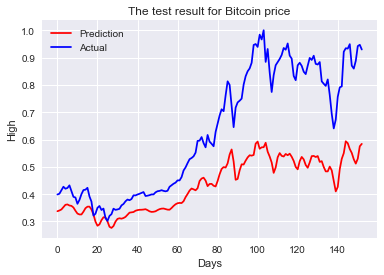

In [46]:
newp = denormalize(p)
newy_test = denormalize(y_test)
plt2.plot(newp, color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.title('The test result for {}'.format("Bitcoin price"))
plt2.xlabel('Days')
plt2.ylabel('High')
plt2.show()